# Fast Fourier Transform

So far we have been working with the _discrete Fourier transform_ (DFT).  This does what we want, but its complexity scales like $\mathcal{O}(N^2)$, so for really large datasets, it will be slow.

*The fast Fourier transform (FFT) is algebraically identical to the DFT*, but uses some clever tricks to speed up the computation, resulting in an algorithm that scales like $\mathcal{O}(N\log N)$.

The standard algorithm for the FFT is the [Cooley-Tukey FFT](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm).  Not only does it gain speed from a divide-and-conquer algorithm, it also does the transform _in-place_, saving memory.  We'll only focus on the performance improvement here.

The FFT can be written as:
    
\begin{align*}
F_k &= \sum_{n=0}^{N-1} f_n e^{-2\pi i k n /N} \\
 &=   \sum_{r=0}^{N/2-1} f_{2r} e^{-2\pi i k (2r) / N} +
   \sum_{r=0}^{N/2-1} f_{2r+1} e^{-2\pi i k (2r+1)/N}
\end{align*}

where we simply split the off and even terms.

Now look at the even terms:

$$E_k \equiv \sum_{r=0}^{N/2-1} f_{2r} e^{-2\pi i k (2r)/N} =
   \sum_{r=0}^{N/2-1} f_{2r} e^{-2\pi i k r / (N/2)}$$
   
This is just the DFT of the $N/2$ even samples.

The odd terms are:

\begin{align*}
\sum_{r=0}^{N/2-1} f_{2r+1} e^{-2\pi i k (2r+1)/N} &=
 e^{-2\pi i k/N}   \sum_{r=0}^{N/2-1} f_{2r+1} e^{-2\pi i k r / (N/2)} \\
&\equiv e^{-2\pi i k/N} O_k
\end{align*}

Here, $O_k$ is just the DFT of the $N/2$ odd samples

If we define:
    
$$\omega^k \equiv e^{-2\pi i k /N}$$

then we can write our original transform as:
    
$$F_k = E_k + \omega^k O_k$$

In doing this, we went from one DFT involving $N$ samples to 2 DFTs with $N/2$ samples.  The number of wavenumbers also is cut in half.

Periodicity tells us that:

$$F_{k+N/2} = E_k - \omega^k O_k$$

since $E_k$ and $O_k$ are periodic with $N/2$

Let's consider 8 samples:

$$f_n = \{ f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7 \}$$

* Express this in terms of the FFTs of the even and odd terms:

  $$F_k = \mathcal{F}(f_0, f_2, f_4, f_6) + \omega^k \mathcal{F}(f_1, f_3, f_5, f_7)$$
  
  this is defined for $k = 0, 1, 2, 3$, since that's what each of the $N/2$ samples gets.
  
* The 2nd half of the frequencies are:

  $$F_{k+N/2} = \mathcal{F}(f_0, f_2, f_4, f_6) - \omega^k \mathcal{F}(f_1, f_3, f_5, f_7)$$
  
  This gives $k = 4, 5, 6, 7$
  
So 2 FFTs of 4 samples each gives us the FFT of 8 samples defined over 8 wavenumbers.

We then apply this recursively.

We eventually get down to $N$ FFTs of 1 sample each:

$$\mathcal{F}(f_0) = f_0$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fft(f_n):
    """ perform a discrete Fourier transform.  We use the same
        conventions as NumPy's FFT

        here,

              N-1         -2 pi i n k /N
        F_k = sum  f   exp
              i=0   n

    """

    N = len(f_n)

    if N == 1:
        return f_n
    else:

        # split into even and odd and find the FFTs of each half
        f_even = f_n[0:N:2]
        f_odd = f_n[1:N:2]

        F_even = fft(f_even)
        F_odd = fft(f_odd)

        # combine them.  Each half has N/2 wavenumbers, but due to
        # periodicity, we can compute N wavenumbers
        omega = np.exp(-2*np.pi*1j/N)

        # allocate space for the frequency components -- they are, in general,
        # complex
        F_k = np.zeros((N), dtype=np.complex128)

        oterm = omega**np.arange(N//2)
        F_k[0:N//2] = F_even + oterm * F_odd
        F_k[N//2:] = F_even - oterm * F_odd

    return F_k

We'll also copy over our DFT:

In [3]:
def dft(f_n):
    """perform a discrete Fourier transform"""
    
    N = len(f_n)
    n = np.arange(N)
    
    f_k = np.zeros((N), dtype=np.complex128)

    for k in range(N):
        f_k[k] = np.sum(f_n * np.exp(-2.0 * np.pi * 1j * n * k / N))
    return f_k

Let's create some data and time how long each takes

In [4]:
def data(xmin=0.0, xmax=50.0, npts=32):
    """create a multi-frequency, multi-phase sine dataset"""
    
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    # number of frequencies to superpose
    nfreq = 48

    # frequency in terms of 1/length
    freqs = np.random.randint(1, npts, nfreq) / xmax
    phases = np.random.uniform(0.0, 2.0*np.pi, nfreq)
    
    f_n = np.zeros_like(xx)
    for f, p in zip(freqs, phases):
        f_n += np.sin(2.0*np.pi*f*xx + p)

    return xx, f_n

In [5]:
xmax = 50.0
xx, f_n = data(xmax=xmax, npts=512)

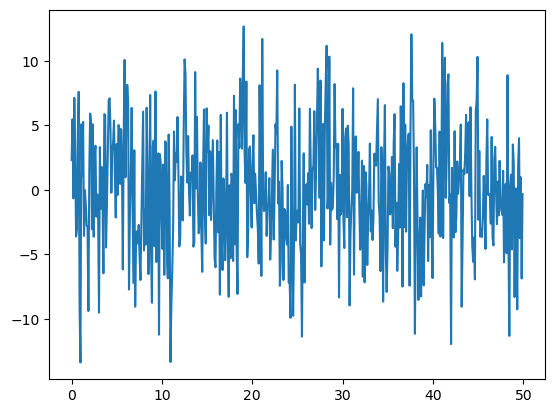

In [6]:
fig, ax = plt.subplots()

ax.plot(xx, f_n)

Let's ensure they get the same answer

In [7]:
f_k_dft = dft(f_n)
f_k_fft = fft(f_n)

N = len(f_k_dft)
k = np.arange(N) / xmax

Text(0, 0.5, '$|F_k|$')

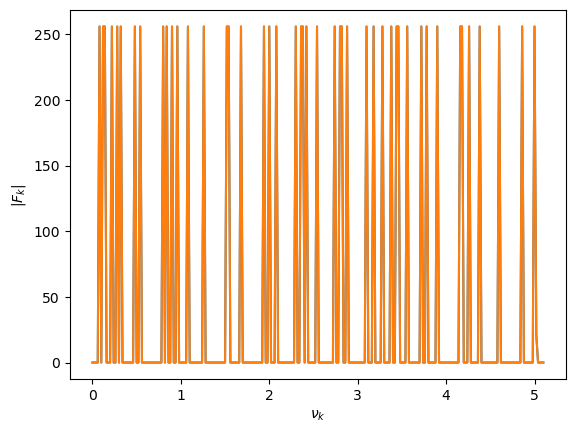

In [8]:
fig, ax = plt.subplots()

ax.plot(k[:N//2], np.abs(f_k_dft[:N//2]))
ax.plot(k[:N//2], np.abs(f_k_fft[:N//2]))

ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel(r"$|F_k|$")

Now let's time them

In [9]:
import time

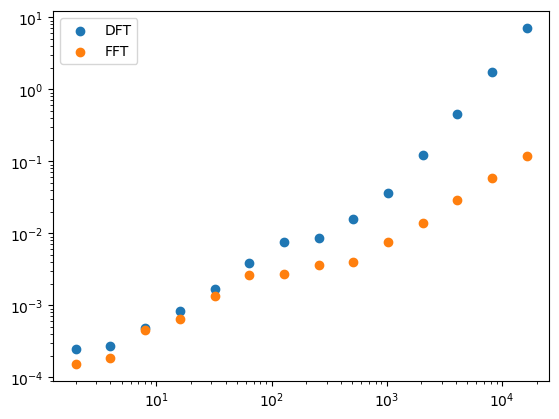

In [10]:
Ns = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

dft_times = []
fft_times = []

for N in Ns:
    xx, f_n = data(npts=N)
    
    start = time.perf_counter()
    f_k_dft = dft(f_n)
    dft_times.append(time.perf_counter() - start)
    
    start = time.perf_counter()
    f_k_fft = fft(f_n)
    fft_times.append(time.perf_counter() - start)
    
fig, ax = plt.subplots()

ax.scatter(Ns, dft_times, label="DFT")
ax.scatter(Ns, fft_times, label="FFT")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")